In [17]:
%pip install --upgrade pip
%pip install transformers torch torchvision
%pip install devinterp
%pip install numpy 

import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
# if you want to use your TPU (note that torch_xla is not by default installed, install using pip install devinterp[tpu]) 
# import os 
# os.environ["USE_TPU_BACKEND"] = "1" 
# import torch_xla.core.xla_model as xm 
# DEVICE = xm.xla_device()

import warnings

import torch
import torchvision
from torch.nn import functional as F
from transformers import AutoModelForImageClassification

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Using device: cpu
Vocab size: 29, d_model: 361
Trainable parameters: 7,996,744

=== Testing Model Accuracy (should be ~100%) ===
Accuracy: 1.0000 (10000/10000)
✓ Perfect accuracy! Ready for LLC estimation.

=== Estimating Learning Coefficient ===


Chain 9: 100%|██████████| 150/150 [01:12<00:00,  2.06it/s]


=== LLC Results ===
LLC means per chain: [ -1.4046307    1.1403242   -2.0302339   -2.3214545   -2.6815634
  -1.6713917   -1.1741228   -4.0665827   -3.9253368   -2.6609206
  -2.8805213   -3.667099    -3.3494039   -5.4981446   -5.1868787
  -5.4065833   -7.5644674   -4.0376873    3.8371577    7.0743265
  12.061232    11.099297     3.9837239    2.562885     6.685727
  -1.4351254    3.1933675   -3.371961    -1.6123343   17.124512
  -5.53792     -5.162666    -6.3254347   -3.6694407   -4.1768284
  -5.1538906   -4.783853    -4.0199227   -4.3240843   -5.277316
  -3.5361435    5.797038    -3.080924     3.6076732   -1.4287369
  -4.4980392  114.868225    40.113785    19.835175     5.804298
  25.99761      1.3925936   13.937009    47.008003    10.738945
  22.034029    21.25981     13.442714    20.589115    12.37271
   8.4969845    7.9346757   11.559019    12.175864     6.2411427
  -0.79343534   0.15904875  11.357509     9.928676    32.17716
   0.3853918   -1.0480385   -2.5598478   -1.7276218   -0.

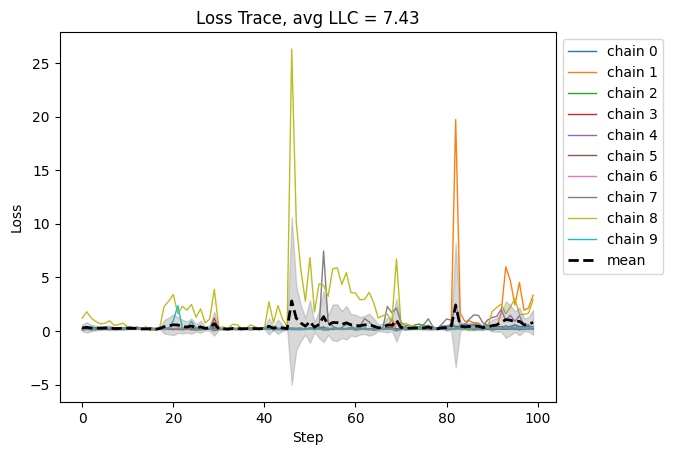

<Figure size 1200x900 with 0 Axes>

In [18]:
from palindrome import check_palindrome
from tracr.haiku_to_pytorch import haiku_to_pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

bos = "BOS"
init_model = check_palindrome()
base_model = haiku_to_pytorch(init_model)

init_vocab = ['a', 'b', 'c', 'd', 'e']
init_label = lambda data: int(list(data) == list(data)[::-1])
init_seq_len = 5

token_to_idx = init_model.input_encoder.encoding_map
vocab_list = list(token_to_idx.keys())
vocab_size = init_model.input_encoder.vocab_size
d_model = base_model.layers[0].attn.d_model
max_pos = init_model.params['pos_embed']['embeddings'].shape[0]

print(f"Vocab size: {vocab_size}, d_model: {d_model}")

class TracrWithEmbeddings(nn.Module):
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.base_model = base_model
        self.token_to_idx = token_to_idx
        self.vocab_size = vocab_size
        
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
    
    def forward(self, x):
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(x_indices.shape[1], device=x_indices.device))
        x = tok_emb + pos_emb
        
        for layer in self.base_model.layers:
            x = layer(x)
        
        return x

base_transformer = TracrWithEmbeddings(base_model, vocab_size, d_model, max_pos, token_to_idx, init_model)
base_transformer = base_transformer.to(DEVICE)

# Use the correct dimension!
PALINDROME_DIM = 331

class TracrPalindromeClassifier(nn.Module):
    """
    Extract palindrome result by checking if ALL positions
    (except BOS) have high values in dimension 331.
    """
    def __init__(self, transformer, palindrome_dim):
        super().__init__()
        self.transformer = transformer
        self.palindrome_dim = palindrome_dim
    
    def forward(self, x):
        hidden = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Get the palindrome indicator for all positions except BOS (position 0)
        palindrome_indicators = hidden[:, 1:, self.palindrome_dim]  # (batch, seq_len-1)
        
        # A sequence is a palindrome if ALL positions have indicator > 0.5
        # Take the minimum value across all positions
        min_indicator = palindrome_indicators.min(dim=1)[0]  # (batch,)
        
        # Convert to logits: if min > 0.5, it's a palindrome
        logits = torch.stack([1.0 - min_indicator, min_indicator], dim=1)
        
        return logits

model = TracrPalindromeClassifier(base_transformer, PALINDROME_DIM)

# Make parameters trainable for LLC
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Dataset
class GeneralDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples):
        self.vocab = vocab
        self.seq_len = seq_len
        self.num_samples = num_samples
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        label = init_label(seq)
        full_seq = ["BOS"] + seq
        return full_seq, label

def custom_collate(batch):
    sequences, labels = zip(*batch)
    return list(sequences), torch.tensor(labels, dtype=torch.long)

vocab = init_vocab 
data = GeneralDataset(vocab=vocab, seq_len=init_seq_len, num_samples=10000) 
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True, collate_fn=custom_collate)

def evaluate(model, batch):
    sequences, labels = batch  
    labels = labels.to(DEVICE)
    logits = model(sequences)
    loss = F.cross_entropy(logits, labels)
    return loss

# Test accuracy
print("\n=== Testing Model Accuracy (should be ~100%) ===")
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in loader:
        sequences, labels = batch
        logits = model(sequences)
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels.to(DEVICE)).sum().item()
        total += len(labels)
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f} ({correct}/{total})")
    
    if accuracy > 0.99:
        print("✓ Perfect accuracy! Ready for LLC estimation.")
    else:
        print(f"⚠️ Accuracy only {accuracy:.2%}. Something still wrong.")

model.train()

# Now estimate LLC!
print("\n=== Estimating Learning Coefficient ===")

learning_coeff_stats = estimate_learning_coeff_with_summary(
    model,
    loader=loader,
    evaluate=evaluate,
    sampling_method=SGLD,
    optimizer_kwargs=dict(
        lr=1e-6,  # Very conservative to prevent NaN
        localization=0.01,  # Very low since loss should be near 0
        nbeta=default_nbeta(loader)
    ),
    num_chains=10,
    num_draws=100,
    num_burnin_steps=50,
    num_steps_bw_draws=1,
    device=DEVICE,
    online=True,
)

trace = learning_coeff_stats["loss/trace"]
print("\n=== LLC Results ===")
print(f"LLC means per chain: {learning_coeff_stats['llc/means']}")
print(f"LLC stds per chain: {learning_coeff_stats['llc/stds']}")
print(f"Average LLC: {np.mean(learning_coeff_stats['llc/means']):.2f}")
print(f"Std across chains: {np.std(learning_coeff_stats['llc/means']):.2f}")

plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {np.mean(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)